In [1]:
# Import modules
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import numpy as np
import datetime
from datetime import datetime as dt
import seaborn as sns

import re

import requests
from bs4 import BeautifulSoup as soup

import pyxlsb
from pyxlsb import convert_date

%qtconsole

In [2]:
# Define local directories
master_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\'
data_raw_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\raw\\'
data_interim_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\interim\\'
data_external_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\external\\'

rig_filename = 'nam_rig-count_by-basin_weekly.csv'
eia_filename = 'eia_data_weekly.csv'
merged_filename = 'merged_data.csv'

In [3]:
# Load csv into dataframe
df_rig = pd.read_csv(data_interim_dir + rig_filename)
df_eia = pd.read_csv(data_interim_dir + eia_filename)

df_rig.date = pd.to_datetime(df_rig.date)
df_eia.date = pd.to_datetime(df_eia.date)

# What am I trying to model?

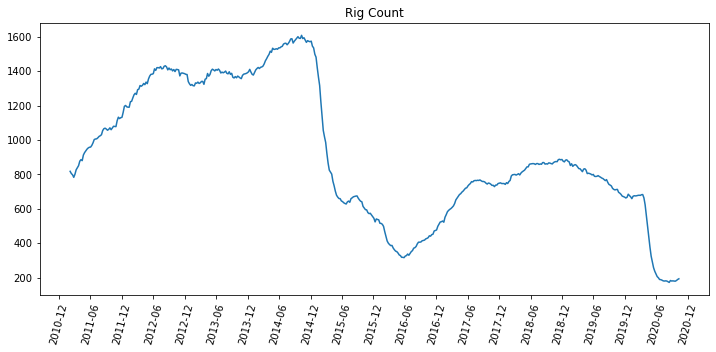

In [4]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_rig.date,df_rig['Total US RigCount'])
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth = range(0,13,6)))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
ax.set_title('Rig Count')
plt.xticks(rotation=75)
plt.show()

## Rig Count Dataset
#### Are there any redundancies here?

In [5]:
df_rig.describe().T

,count,mean,std,min,25%,50%,75%,max
Ardmore Woodford,506.0,3.926877,3.421624,0.0,1.00,3.0,6.00,14.0
Arkoma Woodford,506.0,0.571146,1.430875,0.0,0.00,0.0,0.00,7.0
Barnett,506.0,6.863636,6.297507,0.0,1.00,4.0,12.00,23.0
Cana Woodford,506.0,32.171937,19.898457,0.0,16.00,30.0,45.00,76.0
DJ-Niobrara,506.0,24.235178,8.630250,4.0,19.00,24.0,29.00,50.0
Eagle Ford,506.0,103.472332,61.711146,8.0,60.00,72.0,165.00,214.0
Fayetteville,506.0,0.059289,0.289148,0.0,0.00,0.0,0.00,3.0
Granite Wash,506.0,23.891304,20.869278,0.0,8.00,14.0,43.00,75.0
Haynesville,506.0,0.824111,0.939081,0.0,0.00,1.0,1.00,4.0
Marcellus,506.0,0.126482,0.412443,0.0,0.00,0.0,0.00,2.0


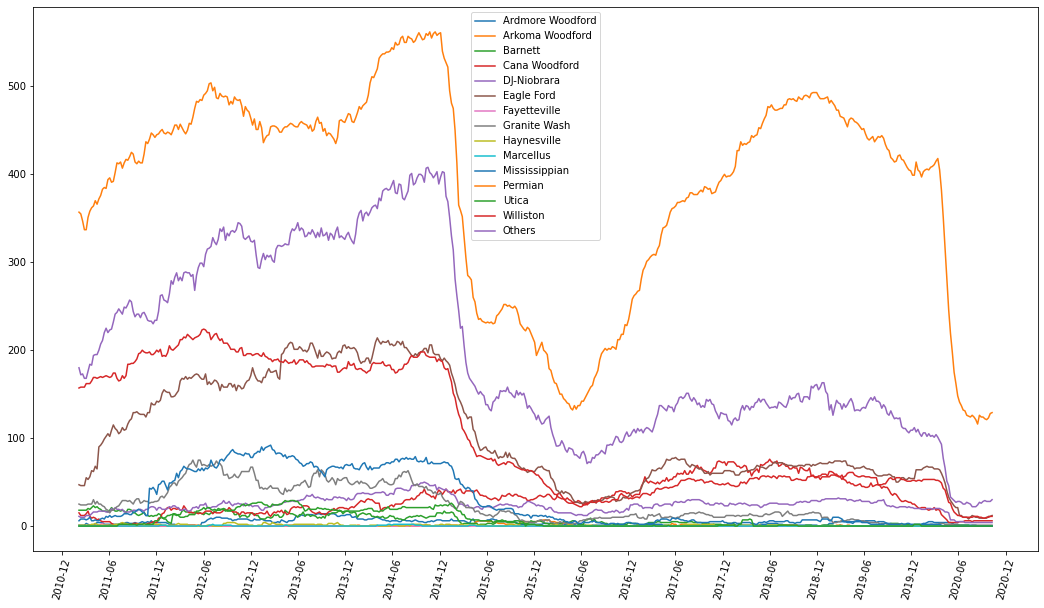

In [6]:
fig, ax = plt.subplots(figsize=(18,10))
for i in range(1,len(df_rig.columns)-1):
    ax.plot(df_rig.date,df_rig.iloc[:,i], label =df_rig.iloc[:,i].name)
    
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth = range(0,13,6)))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
plt.legend()
plt.xticks(rotation=75)
plt.show()

They all seem to trend with eachother... are any correlated / not correlated with the total rig count?

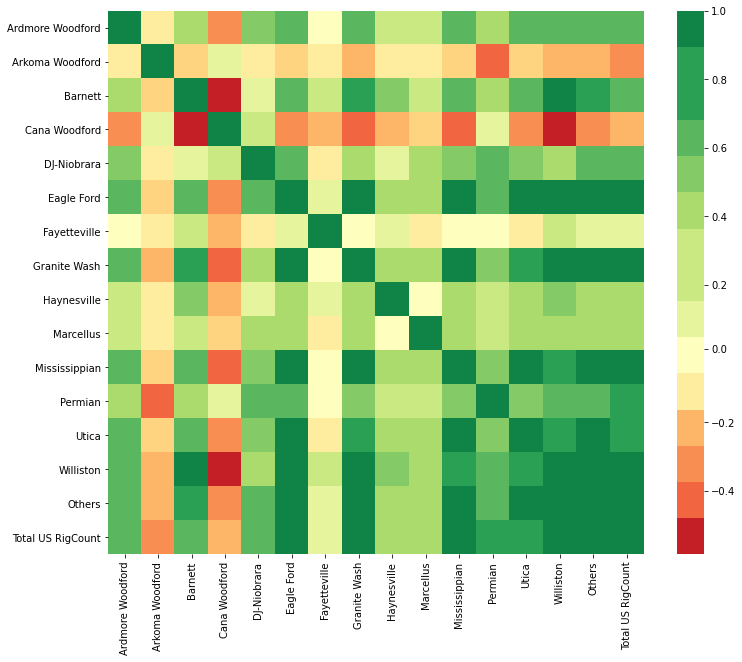

In [7]:
plt.subplots(figsize=(12,10))
corr = df_rig.corr()
distnorm = TwoSlopeNorm(vmin=corr.min().min(),vmax=corr.max().max(),vcenter=0.0)
sns.heatmap(corr,cmap=sns.color_palette("RdYlGn",15),norm=distnorm)

Most show high correlation with Total US Rig Count... Let's investigate further... a lot of basins seem to drop off post 2016 and never recover.

In [8]:
df_rig_clean = df_rig[df_rig.date > '2016-06']
df_rig_clean = df_rig_clean[(df_rig_clean.iloc[:,1:]>20)]
df_rig_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
Ardmore Woodford,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arkoma Woodford,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Barnett,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cana Woodford,191.0,51.502618,15.300800,21.0,39.00,55.0,64.5,76.0
DJ-Niobrara,155.0,26.051613,2.893776,21.0,24.00,26.0,28.0,32.0
Eagle Ford,209.0,58.492823,14.934511,21.0,54.00,64.0,69.0,78.0
Fayetteville,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Granite Wash,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Haynesville,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marcellus,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_rig = df_rig.loc[:,['date','Cana Woodford','DJ-Niobrara','Eagle Ford','Permian','Williston','Total US RigCount']]
df_rig.describe()

,Cana Woodford,DJ-Niobrara,Eagle Ford,Permian,Williston,Total US RigCount
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,32.171937,24.235178,103.472332,384.513834,106.444664,921.749012
std,19.898457,8.630250,61.711146,120.824022,71.278383,393.243781
min,0.000000,4.000000,8.000000,116.000000,9.000000,172.000000
25%,16.000000,19.000000,60.000000,303.500000,49.000000,664.750000
50%,30.000000,24.000000,72.000000,431.000000,61.000000,834.000000
75%,45.000000,29.000000,165.000000,466.750000,184.000000,1354.750000
max,76.000000,50.000000,214.000000,562.000000,224.000000,1609.000000


That looks a bit cleaner... The most important basins are looked at here, but are they still necessary when we have Total US RigCount to look at?

## EIA Dataset

Are there any redundancies here?

In [10]:
df_eia.sort_values('date',ascending=False).head()

,date,wti_spot,brent_spot,wti_fut_1,wti_fut_2,wti_fut_3,wti_fut_4,usa_net_import,usa_stocks_all,usa_stocks_spr,usa_l48_prod,opec_tot_prod,opec_crud_capac,opec_surp_capac,non-opec_tot_prod,oecd_cons,non-oecd_cons,world_cons
560,2020-09-25,39.780,40.890,39.880,40.1300,40.4360,40.7640,1.610,1135.577,643.151,10.3,29.435122,31.697833,7.094833,63.063193,43.702403,52.057515,95.759918
559,2020-09-18,39.554,40.770,39.556,39.8120,40.1560,40.5500,2.146,1139.358,644.952,10.3,29.271614,31.666139,7.234639,62.993766,43.415251,52.199139,95.614390
558,2020-09-11,37.375,39.450,37.360,37.7275,38.1925,38.6775,2.413,1141.778,645.733,10.4,29.108107,31.634444,7.374444,62.924340,43.128099,52.340763,95.468862
557,2020-09-04,41.842,43.060,41.604,41.9400,42.3080,42.6800,2.479,1148.294,647.860,9.5,28.944599,31.602749,7.514249,62.854913,42.840947,52.482387,95.323334
556,2020-08-28,42.932,45.258,43.074,43.3740,43.6880,44.0000,1.898,1146.566,648.165,9.2,28.862164,31.581962,7.576639,62.805609,42.732223,52.357322,95.089545


In [11]:
df_eia.describe().T

,count,mean,std,min,25%,50%,75%,max
wti_spot,561.0,70.082780,23.100293,3.324000,50.360000,67.178000,92.967500,112.296000
brent_spot,561.0,76.903979,27.289544,14.236000,54.402000,72.540000,107.328000,126.624000
wti_fut_1,561.0,70.143579,23.045556,3.920000,50.440000,67.182000,92.850000,112.808000
wti_fut_2,561.0,70.545636,22.719787,19.070000,50.974000,67.032000,93.167500,113.302000
wti_fut_3,561.0,70.835119,22.456862,22.670000,51.504000,66.616000,93.112000,113.578000
wti_fut_4,561.0,71.037302,22.227572,24.834000,51.986000,66.290000,93.370000,113.692000
usa_net_import,561.0,6.935608,1.904819,1.610000,6.264000,7.275000,8.228000,11.120000
usa_stocks_all,561.0,1090.175660,57.302698,997.074000,1045.523000,1070.960000,1130.288000,1227.678000
usa_stocks_spr,561.0,686.795367,25.582555,634.967000,665.281000,695.083000,695.969000,726.617000
usa_l48_prod,561.0,8.114405,2.280404,4.506000,5.899000,8.287000,9.272000,12.600000


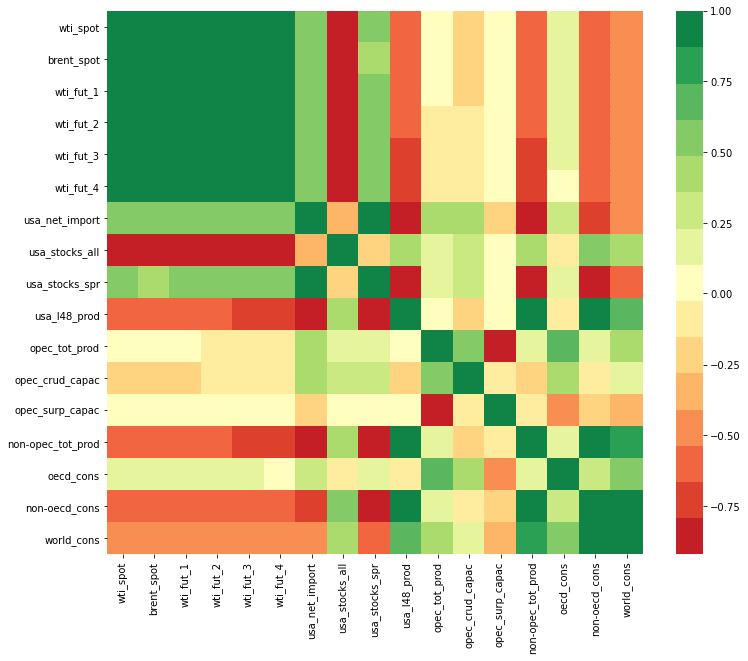

In [12]:
plt.subplots(figsize=(12,10))
corr = df_eia.corr()
distnorm = TwoSlopeNorm(vmin=corr.min().min(),vmax=corr.max().max(),vcenter=0.0)
sns.heatmap(corr,cmap=sns.color_palette("RdYlGn",15),norm=distnorm)

#### Summary

All the oil prices, including future prices, seem to be very similarly tied... Would be good to potentially remove those to simplify the analysis. Lets see how they look.

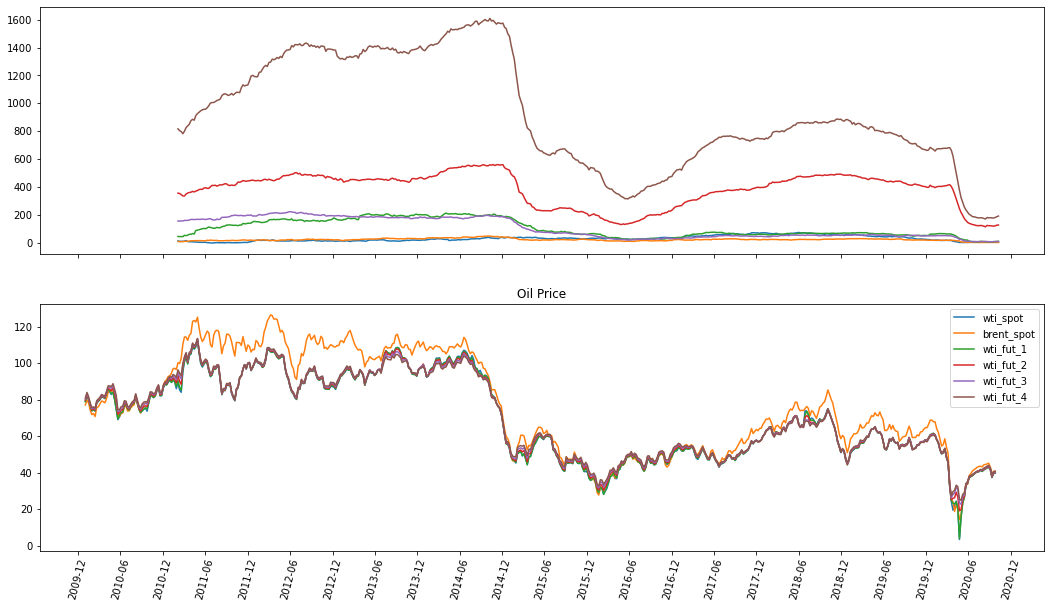

In [13]:
fig, ax = plt.subplots(2, sharex=True, figsize=(18,10))

ax[0].plot(df_rig.date,df_rig.iloc[:,1:])

for col in df_eia.columns[1:7]:
    ax[1].plot(df_eia.date,df_eia.loc[:,col], label =col)
    
ax[1].xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth = range(0,13,6)))
ax[1].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
plt.legend()
plt.title('Oil Price')
plt.xticks(rotation=75)
plt.show()

In [14]:
# Let's try to figure out the lag in wti_spot
shifts = np.arange(0,50,step=1)

shifted_wti = df_eia[['date','wti_spot']].copy()
shifted_wti = shifted_wti.merge(df_rig[['date','Total US RigCount']],how='outer',on='date').sort_values(by='date')

for ii in shifts:
    col_name = 'wti_spot_lag_'+str(ii)
    shifted_wti[col_name] = df_eia.wti_spot.shift(ii)

corr_matrix = shifted_wti.corr()

rig_corr = corr_matrix['Total US RigCount'][2:].sort_values(ascending=False)
rig_corr.head()

wti_spot_lag_15    0.917407
wti_spot_lag_14    0.917361
wti_spot_lag_16    0.916633
wti_spot_lag_13    0.916489
wti_spot_lag_17    0.915013
Name: Total US RigCount, dtype: float64

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(shifted_wti.iloc[:,1:])

X = scaler.transform(shifted_wti.iloc[:,1:])
X = pd.DataFrame(X, columns=shifted_wti.iloc[:,1:].columns)

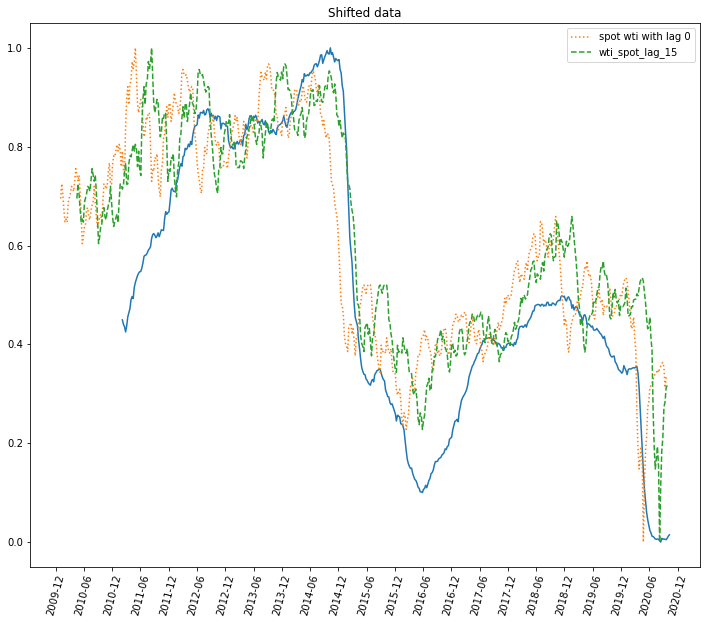

In [16]:
fig, ax = plt.subplots(figsize=(12,10))
ax.plot(shifted_wti.date,X['Total US RigCount'])
ax.plot(shifted_wti.date,X['wti_spot_lag_0'],label='spot wti with lag 0',linestyle='dotted')
ax.plot(shifted_wti.date,X[rig_corr.index[0]],label=rig_corr.index[0],linestyle='dashed')
ax.legend()
ax.set_title('Shifted data')
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth = range(0,13,6)))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
plt.xticks(rotation=75)
plt.show()


wti_spot_lag_14 doesn't seem to match so well with the latest downturn, is there a better lag for that?

In [17]:
# finding lag from wti_spot using data from 2016-06
shifts = np.arange(0,50,step=1)

shifted_wti_2016 = shifted_wti[shifted_wti.date > '2016-06']

corr_matrix = shifted_wti_2016.corr()

rig_corr_2016 = corr_matrix['Total US RigCount'][2:].sort_values(ascending=False).head(10)
rig_corr_2016

wti_spot_lag_9     0.803256
wti_spot_lag_10    0.802449
wti_spot_lag_8     0.800823
wti_spot_lag_11    0.799150
wti_spot_lag_7     0.795104
wti_spot_lag_12    0.792991
wti_spot_lag_6     0.786550
wti_spot_lag_13    0.784727
wti_spot_lag_14    0.774182
wti_spot_lag_5     0.773741
Name: Total US RigCount, dtype: float64

Looks like wti_spot_lag_9 works better, here though lag_14 isn't so far behind in terms of correlation.

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X = shifted_wti_2016[['date',rig_corr_2016.index[0],'wti_spot_lag_0','Total US RigCount']]

scaler.fit(X.iloc[:,1:])

X = scaler.transform(X.iloc[:,1:])
X = pd.DataFrame(X,columns=[rig_corr_2016.index[0],'wti_spot_lag_0','Total US RigCount'])

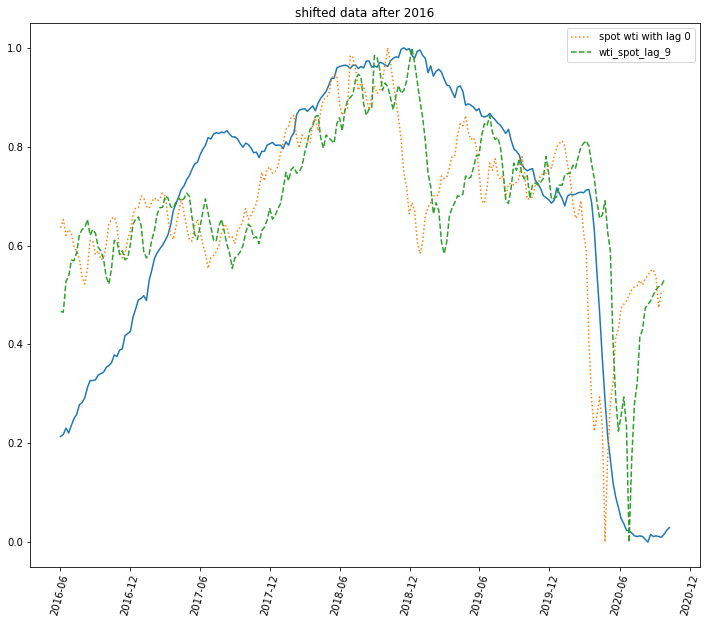

In [19]:
fig, ax = plt.subplots(figsize=(12,10))
ax.plot(shifted_wti_2016.date,X['Total US RigCount'])
ax.plot(shifted_wti_2016.date,X['wti_spot_lag_0'],label='spot wti with lag 0',linestyle='dotted')
ax.plot(shifted_wti_2016.date,X[rig_corr_2016.index[0]],label=rig_corr_2016.index[0],linestyle='dashed')
ax.legend()
ax.set_title('shifted data after 2016')
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth = range(0,13,6)))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
plt.xticks(rotation=75)
plt.show()


In [20]:
shifted_wti[['date',rig_corr.index[0],rig_corr_2016.index[0],'wti_spot_lag_0','Total US RigCount']].iloc[:-2,:].tail(15)

,date,wti_spot_lag_15,wti_spot_lag_9,wti_spot_lag_0,Total US RigCount
546,2020-06-19,45.574,20.120,38.350,189.0
547,2020-06-26,32.386,3.324,39.220,188.0
548,2020-07-03,24.194,15.712,39.992,185.0
549,2020-07-10,19.438,23.464,40.442,181.0
550,2020-07-17,21.686,26.398,40.570,180.0
551,2020-07-24,24.405,33.096,41.338,181.0
552,2020-07-31,20.120,34.185,40.686,180.0
553,2020-08-07,3.324,37.322,41.568,176.0
554,2020-08-14,15.712,37.872,42.076,172.0
555,2020-08-21,23.464,38.350,42.726,183.0


#### Summary 
WTI and Brent are good - both follow the rig count pretty well (with an identified lag of 15 weeks) until the most recent crash. Prices recover, but the rig count does not reflect the quick recovery in price.

WTI futures are pretty consistent with WTI spot price. Need to figure out a good way to utilise this (use to reflect market investment on expected future prices?), or figure out if it's even a useful tool.

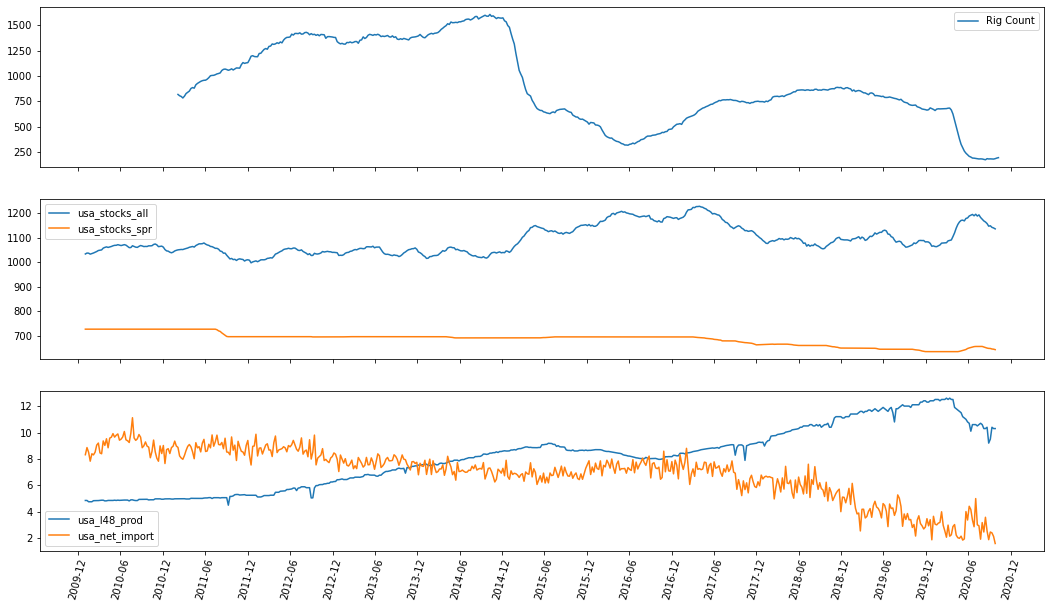

In [21]:
fig, ax = plt.subplots(3,sharex=True,figsize=(18,10))

ax[0].plot(df_rig.date,df_rig['Total US RigCount'], label ='Rig Count')
  
for col in ['usa_stocks_all','usa_stocks_spr']:
    ax[1].plot(df_eia.date,df_eia.loc[:,col], label =col)
    
for col in ['usa_l48_prod','usa_net_import']:
    ax[2].plot(df_eia.date,df_eia.loc[:,col], label =col)

for i in range(0,3):
    ax[i].legend()
    
ax[2].xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth = range(0,13,6)))
ax[2].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))


plt.xticks(rotation=75)
plt.show()

use_net_import and usa_l48_prod both show quite a lot of variance and specifically in usa_l48_prod potential outliers causing those deep "dips". Can try to smooth those out so they're a bit more consistent.

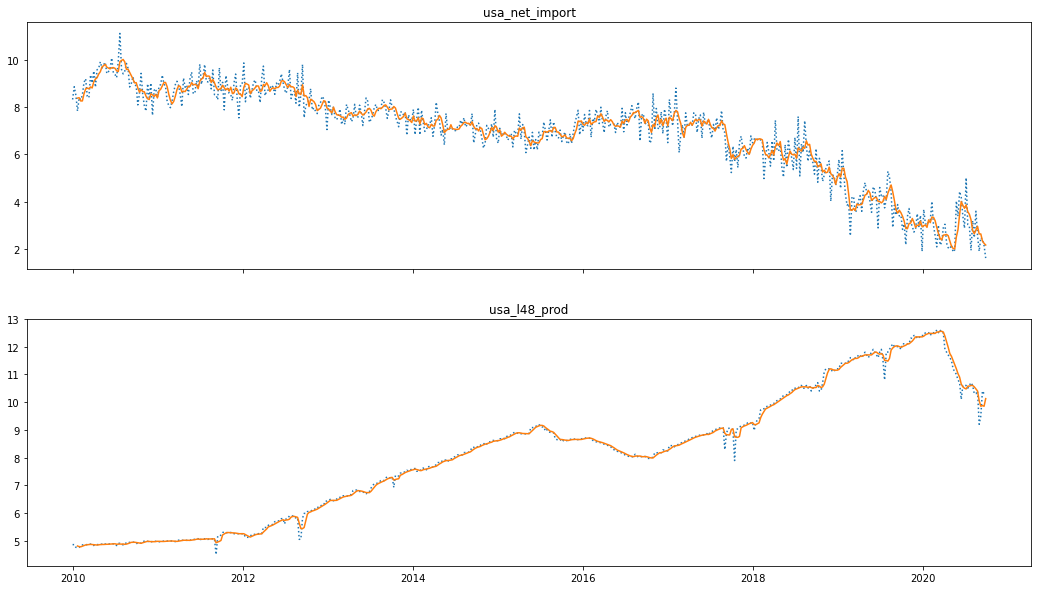

In [22]:
import_roll = df_eia['usa_net_import'].rolling(window=4).mean()
prod_roll = df_eia['usa_l48_prod'].rolling(window=4).mean()

fig, ax = plt.subplots(2,sharex=True,figsize=(18,10))
ax[0].plot(df_eia.date,df_eia.usa_net_import,linestyle='dotted')
ax[0].plot(df_eia.date,import_roll)
ax[0].set_title('usa_net_import')

ax[1].plot(df_eia.date,df_eia.usa_l48_prod,linestyle='dotted')
ax[1].plot(df_eia.date,prod_roll)
ax[1].set_title('usa_l48_prod')

plt.show()

#### Summary
Stocks increase after the crash in price in 2014. 
SPR stocks don't really seem to show too much here.
Net imports seem to drop consistently throughout the timeline listed.
Smoothing definitely helps with the variance in the data.

## OPEC and Non-OPEC Production

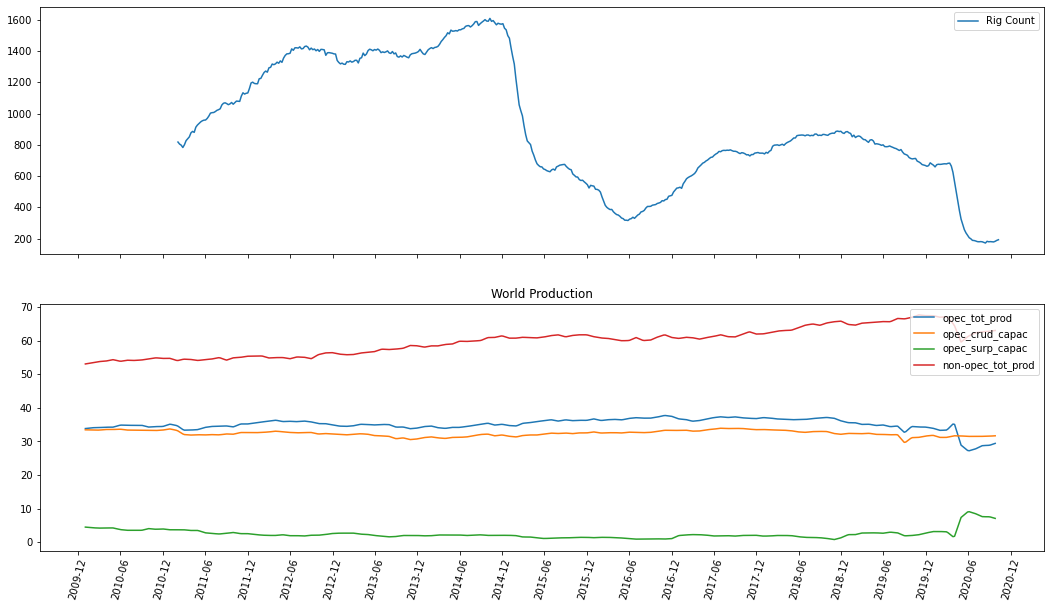

In [23]:
fig, ax = plt.subplots(2,sharex=True,figsize=(18,10))
plt.title('World Production')

ax[0].plot(df_rig.date,df_rig['Total US RigCount'], label ='Rig Count')
ax[0].legend()

for col in df_eia.columns[11:15]:
    ax[1].plot(df_eia.date,df_eia.loc[:,col], label =col)
    
ax[1].xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth = range(0,13,6)))
ax[1].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
ax[1].legend()
plt.xticks(rotation=75)
plt.show()

#### Summary
Non OPEC production has been outpacing OPEC production since early 2010's.
OPEC production or capacity doesn't seem to change much during the first oil price crash but has significant correlation with the most recent price crash.

## World and OECD Consumption

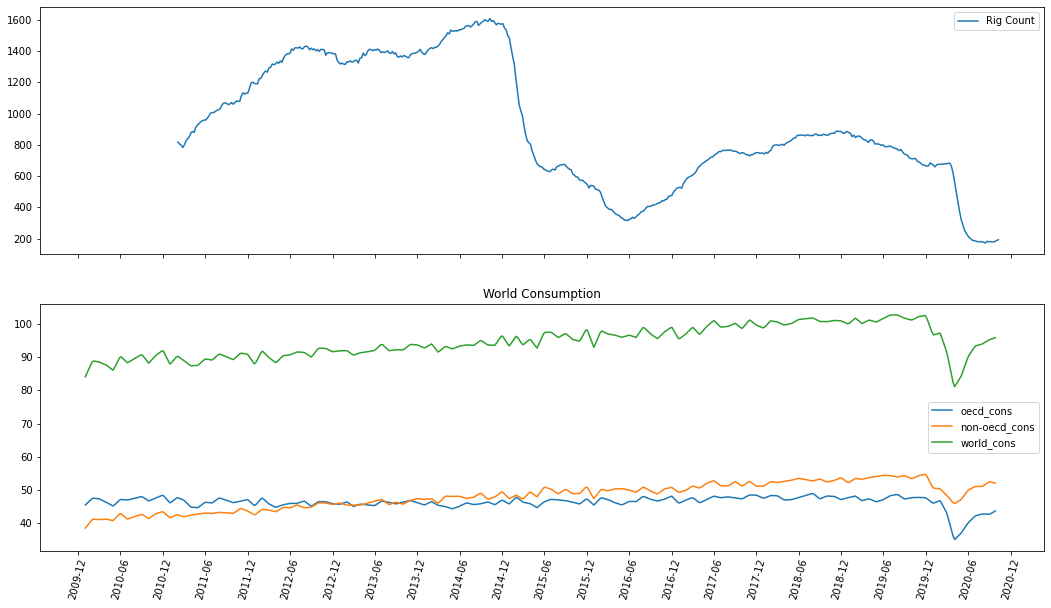

In [24]:
fig, ax = plt.subplots(2,sharex=True,figsize=(18,10))
plt.title('World Consumption')

ax[0].plot(df_rig.date,df_rig['Total US RigCount'], label ='Rig Count')
ax[0].legend()

for col in df_eia.columns[15:18]:
    ax[1].plot(df_eia.date,df_eia.loc[:,col], label =col)
    
ax[1].xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth = range(0,13,6)))
ax[1].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
ax[1].legend()
plt.xticks(rotation=75)
plt.show()

World consumption might benefit from smoothing as well as there's quite a lot of variance between data points.

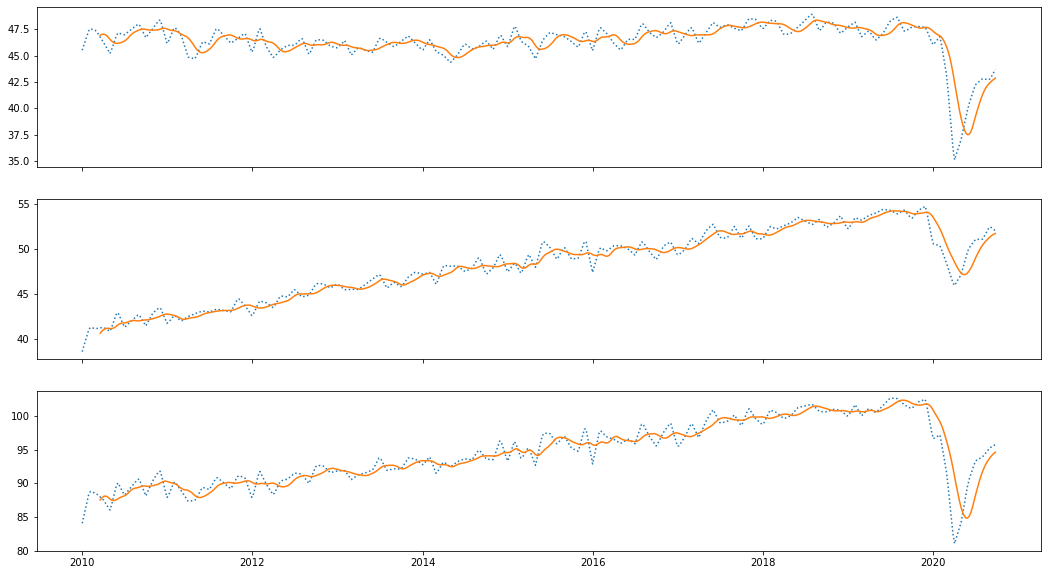

In [25]:
window = 12

cons_oecd_roll = df_eia['oecd_cons'].rolling(window=window).mean()
cons_non_oecd_roll = df_eia['non-oecd_cons'].rolling(window=window).mean()
cons_world_roll = df_eia['world_cons'].rolling(window=window).mean()

fig, ax = plt.subplots(3,sharex=True,figsize=(18,10))
ax[0].plot(df_eia.date,df_eia.oecd_cons,linestyle='dotted')
ax[0].plot(df_eia.date,cons_oecd_roll)

ax[1].plot(df_eia.date,df_eia['non-oecd_cons'],linestyle='dotted')
ax[1].plot(df_eia.date,cons_non_oecd_roll)

ax[2].plot(df_eia.date,df_eia.world_cons,linestyle='dotted')
ax[2].plot(df_eia.date,cons_world_roll)

plt.show()

#### World Consumption Summary 

Nothing seems to correlate well with both the crashes in 2014 and 2020. In addition US Rig Count is not recovering as quickly as with the other data points.

### EIA Dataset summary

The futures prices right now I think should be removed as they don't vary enough from the WTI spot prices, even looking ahead four months in the future. Brent is at the same risk there, however, I'm willing to keep that feature in to provide a bit of balance for world oil market.

In [26]:
#df_eia = df_eia.drop(df_eia.columns.to_list()[3:7],axis=1)
#df_eia = df_eia.drop('usa_stocks_spr',axis=1)

df_eia.insert(df_eia.columns.to_list().index('wti_spot'),'wti_spot_lag_15',shifted_wti['wti_spot_lag_14'])
df_eia.insert(df_eia.columns.to_list().index('wti_spot'),'wti_spot_lag_9',shifted_wti['wti_spot_lag_9'])

# rolling values for usa_net_imports and usa_l48_prod
df_eia.insert(df_eia.columns.to_list().index('usa_net_import'),'usa_net_import_smooth',import_roll)
df_eia.insert(df_eia.columns.to_list().index('usa_l48_prod'),'usa_l48_prod_smooth',prod_roll)

# rolling values for consumption
df_eia.insert(df_eia.columns.to_list().index('oecd_cons'),'oecd_cons_smooth',shifted_wti['wti_spot_lag_9'])
df_eia.insert(df_eia.columns.to_list().index('non-oecd_cons'),'non-oecd_cons_smooth',shifted_wti['wti_spot_lag_9'])
df_eia.insert(df_eia.columns.to_list().index('world_cons'),'world_cons_smooth',shifted_wti['wti_spot_lag_9'])

df_eia.head()

,date,wti_spot_lag_15,wti_spot_lag_9,wti_spot,brent_spot,wti_fut_1,wti_fut_2,wti_fut_3,wti_fut_4,usa_net_import_smooth,...,opec_tot_prod,opec_crud_capac,opec_surp_capac,non-opec_tot_prod,oecd_cons_smooth,oecd_cons,non-oecd_cons_smooth,non-oecd_cons,world_cons_smooth,world_cons
0,2010-01-01,NaN,NaN,79.0700,77.1925,79.070,79.7725,80.4600,81.005,NaN,...,33.855902,33.477104,4.500000,53.096293,NaN,45.532183,NaN,38.541242,NaN,84.073425
1,2010-01-08,NaN,NaN,82.3440,79.8180,82.374,82.9540,83.5140,84.052,NaN,...,33.912050,33.465622,4.454839,53.178151,NaN,45.995785,NaN,39.155907,NaN,85.151692
2,2010-01-15,NaN,NaN,80.0600,78.3100,80.070,80.4940,81.0580,81.676,NaN,...,33.968198,33.454139,4.409677,53.260008,NaN,46.459387,NaN,39.770573,NaN,86.229960
3,2010-01-22,NaN,NaN,76.6225,74.2825,76.815,77.1275,77.6575,78.260,8.38175,...,34.024346,33.442657,4.364516,53.341866,NaN,46.922989,NaN,40.385238,NaN,87.308227
4,2010-01-29,NaN,NaN,73.9360,71.8820,74.034,74.4820,75.0680,75.632,8.39925,...,34.080494,33.431175,4.319355,53.423723,NaN,47.386591,NaN,40.999903,NaN,88.386495


## Merged dataset.

We've looked at the data broken up and individually and have tried to find relationships with Total US RigCount. Are there any relationships that we can check out when merged?

In [27]:
# Merge two files into one dataframe
df_merge = df_rig.merge(df_eia, how='outer',on='date').sort_values(by=['date'], ascending=False).reset_index(drop=True)
df_merge = df_merge[(df_merge.date >= '2011-02-01')]# & (df_merge.date <= dt.now().date().strftime('%Y-%m')+'-01')]

# Save merged file as csv
df_merge.to_csv(data_interim_dir+'merged_data_weekly.csv',index=False)

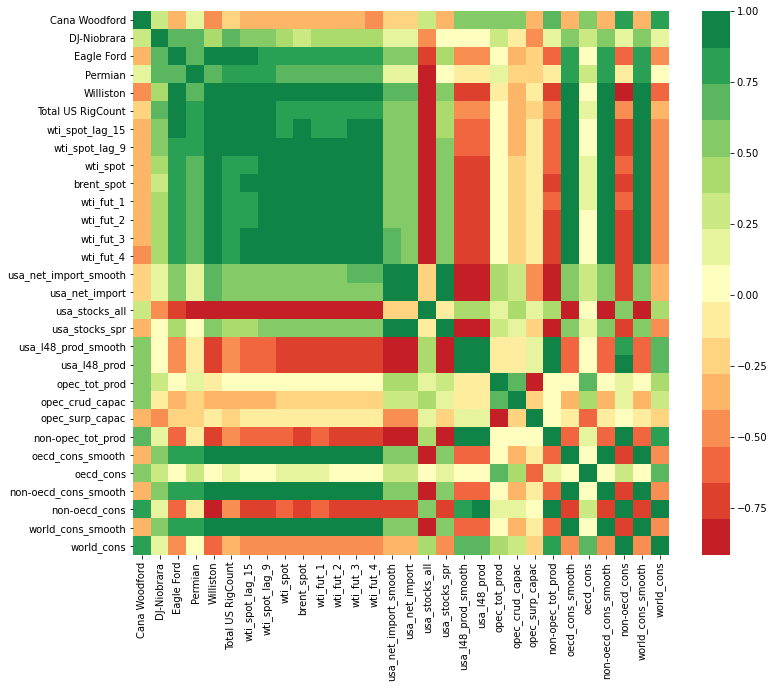

In [28]:
plt.subplots(figsize=(12,10))
corr = df_merge.corr()
distnorm = TwoSlopeNorm(vmin=corr.min().min(),vmax=corr.max().max(),vcenter=0.0)
sns.heatmap(corr,cmap=sns.color_palette("RdYlGn",15),norm=distnorm)

#### Correlation Summary - Full dates

Most surprisingly the L48 USA production does not model well with the Total Rig Count (-0.25 or so correlation value). However, this could be due to a number of reasons. 
1. Unconventional wells have a very short production curves, meaning the wells show more production but over a shorter period of time. This would shows that current activity actually maintains the current production as opposed to increases overall production.
2. Drilling wells doesn't mean production. They have to be completed before they can actually produce. Often times companies will drill a well and put it in a schedule to be completed for a later date (Drilled Uncompleted).

WTI Spot prices seems to be the lone bright star to show a high level of correlation with rig count as expected from visual data, but can it predict a recovery in the number of active drilling rigs? We do have a number of factors that negatively correlate with total US rig count that could help balance that factor, mainly when it comes to the EIA data. Could these factors help balance out the lack of rig count recovery with the recent price recovery to 40USD oil?

What about if we try to only analyse the rig count since the recovery in 2016?

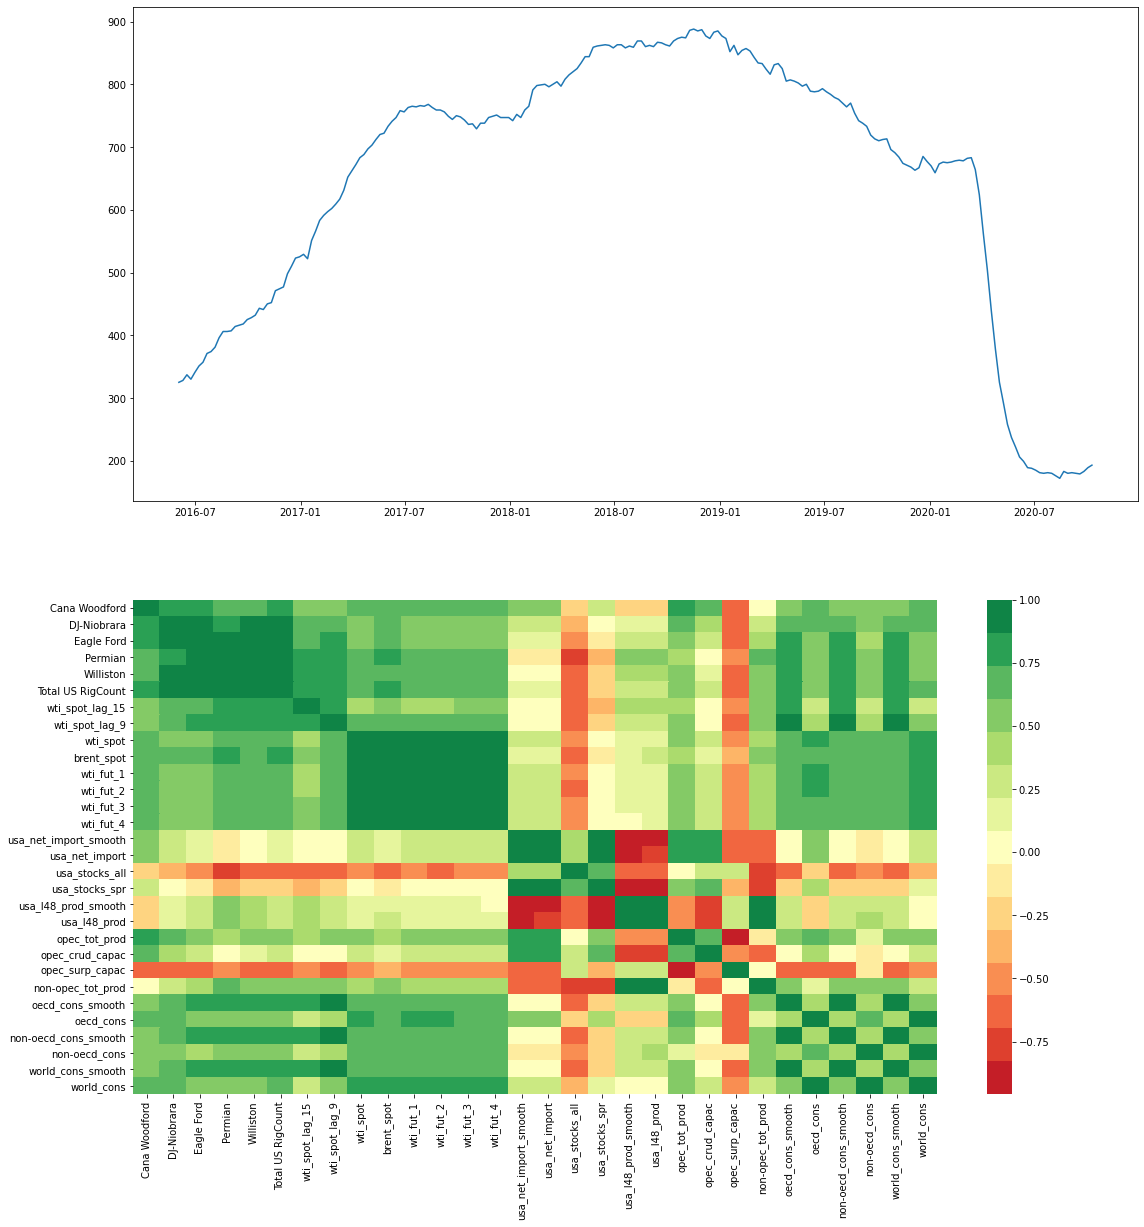

In [29]:
df_merge_2016 = df_merge[df_merge.date > '2016-06-01']
fig, ax = plt.subplots(2,figsize=(18,20))

ax[0].plot(pd.to_datetime(df_merge_2016['date']),df_merge_2016['Total US RigCount'], label ='Rig Count')

corr = df_merge_2016.corr()
distnorm = TwoSlopeNorm(vmin=corr.min().min(),vmax=corr.max().max(),vcenter=0.0)
sns.heatmap(corr,cmap=sns.color_palette("RdYlGn",15),norm=distnorm)

#### Correlation Summary - 2016 to present

Now that we're only looking at a given subsection of dates, there are some significant changes: 

There is a lesser positive correlation to WTI prices, though the production, consumption data does show a positive correlation with total rig count. 

There is a strong negative correlation with OPEC Surplus Capacity and USA Oil Stocks which could help predict an recovery in Rig Count.

### Comments

The difficulty in this analysis will be looking at leading factors to help predict. Is an offset with some of the data going to help predict something in the future? 

Specifically will the flattening of the OPEC Surplus Capacity be enough to predict the small uptick we're seeing in mid August in Rig Count?

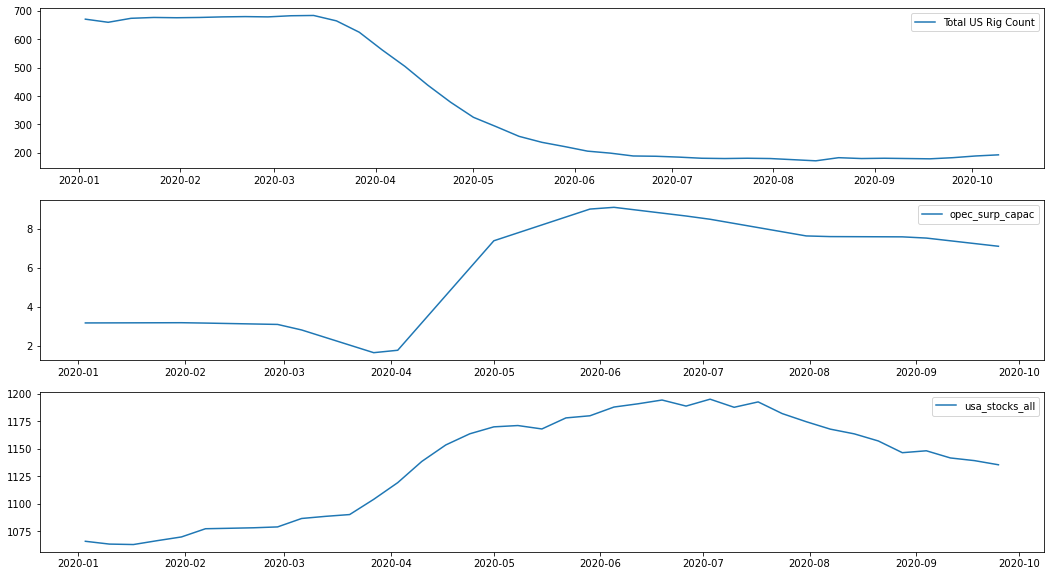

In [30]:
df_merge_2020 = df_merge[df_merge.date > '2020-01-01']
fig, ax = plt.subplots(3,figsize=(18,10))

ax[0].plot(pd.to_datetime(df_merge_2020['date']),df_merge_2020['Total US RigCount'], label ='Total US Rig Count')
ax[0].legend()

ax[1].plot(pd.to_datetime(df_merge_2020['date']),df_merge_2020['opec_surp_capac'], label ='opec_surp_capac')
ax[1].legend()

ax[2].plot(pd.to_datetime(df_merge_2020['date']),df_merge_2020['usa_stocks_all'], label ='usa_stocks_all')
ax[2].legend()

#### Additional data

This seems like a great place to start but here are some thoughts about potential areas to add new data to help :

The oil and gas industry has not been stagnant - significant improvements and efficiencies developed after the first crash in 2014, making it cheaper for companies to drill. The breakeven price for a barrel of oil has reduced significantly. Would this be a good feature to add? Would be able to help model individual basins as well.

E&P companies only drill if they have money to spend. There is a significant amount of debt, and companies are declaring bankruptcy. Do I need more data, perhaps financial health of US oil and gas companies?

## Classification predictive variable

Looking to see how well we can predict the percent change of rig count in the future (1, 2, 3, 4 weeks).
Want to create anti-lag (future) predictive variables and explore what percent change they have based on 'week 0' rig count

In [31]:
from matplotlib.ticker import PercentFormatter

df_rig_shift = df_merge[['date','Total US RigCount']]
df_rig_shift

,date,Total US RigCount
0,2020-10-09,193.0
1,2020-10-02,189.0
2,2020-09-25,183.0
3,2020-09-18,179.0
4,2020-09-11,180.0
...,...,...
501,2011-03-04,801.0
502,2011-02-25,783.0
503,2011-02-18,798.0
504,2011-02-11,805.0


In [32]:
# Create shifted rig counts for weeks 1:9

shifts= [4,8]

for ii in shifts:
    col_name = 'rig_fut_week+'+str(ii)
    df_rig_shift[col_name] = df_merge['Total US RigCount'].shift(ii)
    
df_rig_shift.head(5)                                    

<ipython-input-32-b1fc02bed855>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rig_shift[col_name] = df_merge['Total US RigCount'].shift(ii)


,date,Total US RigCount,rig_fut_week+4,rig_fut_week+8
0,2020-10-09,193.0,NaN,NaN
1,2020-10-02,189.0,NaN,NaN
2,2020-09-25,183.0,NaN,NaN
3,2020-09-18,179.0,NaN,NaN
4,2020-09-11,180.0,193.0,NaN


In [33]:
# Calculate percent change of rig count from week 0

df_rig_shift = df_rig_shift.dropna().reset_index(drop=True)

for ii in shifts:
    col_name = 'rig_pct_change_week+'+str(ii)
    df_rig_shift[col_name] = (df_rig_shift['rig_fut_week+'+str(ii)]-df_rig_shift['Total US RigCount'])/(df_rig_shift['Total US RigCount'])
    
df_rig_shift.head()

,date,Total US RigCount,rig_fut_week+4,rig_fut_week+8,rig_pct_change_week+4,rig_pct_change_week+8
0,2020-08-14,172.0,180.0,193.0,0.046512,0.122093
1,2020-08-07,176.0,181.0,189.0,0.028409,0.073864
2,2020-07-31,180.0,180.0,183.0,0.000000,0.016667
3,2020-07-24,181.0,183.0,179.0,0.011050,-0.011050
4,2020-07-17,180.0,172.0,180.0,-0.044444,0.000000


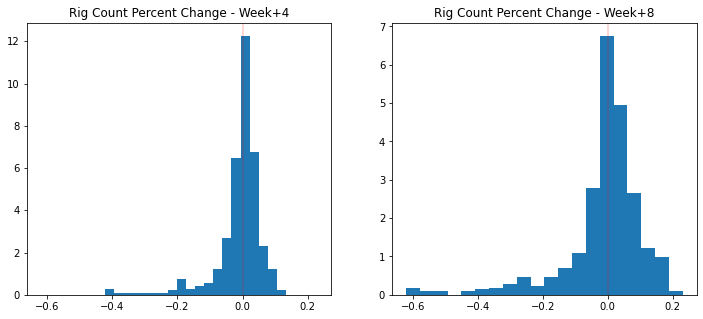

In [46]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5),sharex=True)
ax = ax.flatten()

for ii in range(0,len(shifts)):
    ax[ii].hist(df_rig_shift['rig_pct_change_week+'+str(shifts[ii])],bins=20,density=True)
    ax[ii].axvline(x=0,c='r',alpha=0.2)
    ax[ii].set_title('Rig Count Percent Change - Week+'+str(shifts[ii]))

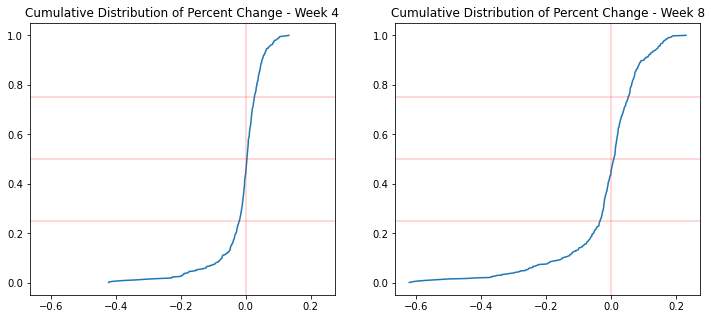

In [50]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5),sharex=True)
ax = ax.flatten()

quantiles = pd.DataFrame(columns=['25%','50%','75%'])

for ii in range(0,len(shifts)):
    x_cdf = df_rig_shift['rig_pct_change_week+'+str(shifts[ii])]
    ax[ii].plot(np.sort(x_cdf),np.arange(1,len(x_cdf)+1)/len(x_cdf))
    ax[ii].axvline(x=0,c='r',alpha=0.2)
    ax[ii].axhline(y=0.25,c='r',alpha=0.2)
    ax[ii].axhline(y=0.5,c='r',alpha=0.2)
    ax[ii].axhline(y=0.75,c='r',alpha=0.2)
    ax[ii].set_title('Cumulative Distribution of Percent Change - Week '+str(shifts[ii]))
    
    quantiles.loc['week+'+str(shifts[ii]),'25%'] = np.quantile(x_cdf,0.25)
    quantiles.loc['week+'+str(shifts[ii]),'50%'] = np.quantile(x_cdf,0.50)
    quantiles.loc['week+'+str(shifts[ii]),'75%'] = np.quantile(x_cdf,0.75)

In [36]:
quantiles

,25%,50%,75%
week+4,-0.0198475,0.00349447,0.0265602
week+8,-0.0335859,0.00822166,0.0525233


In [37]:
for ii in shifts:
    df_rig_shift['rig_change_bin_week+'+str(ii)] = pd.cut(df_rig_shift['rig_pct_change_week+'+str(ii)],bins=[df_rig_shift['rig_pct_change_week+'+str(ii)].min()-0.01,0,df_rig_shift['rig_pct_change_week+'+str(ii)].max()+0.01],labels=['neg','pos'])
    df_rig_shift['rig_change_4bin_week+'+str(ii)] = pd.cut(df_rig_shift['rig_pct_change_week+'+str(ii)],bins=[df_rig_shift['rig_pct_change_week+'+str(ii)].min()-0.01,quantiles.loc['week+'+str(ii),'25%'],0,quantiles.loc['week+'+str(ii),'75%'],df_rig_shift['rig_pct_change_week+'+str(ii)].max()+0.01],labels=['--','-','+','++'])

In [38]:
df_rig_shift.iloc[:,-len(shifts)*2:].head()

,rig_change_bin_week+4,rig_change_4bin_week+4,rig_change_bin_week+8,rig_change_4bin_week+8
0,pos,++,pos,++
1,pos,++,pos,++
2,neg,-,pos,+
3,pos,+,neg,-
4,neg,--,neg,-


In [39]:
#fig, ax = plt.subplots(10,3,figsize=(18,10))
#ax = ax.flatten()

#for ii in shifts:
#    ax[ii-1].bar(df_rig_shift['rig_change_bin_week+'+str(ii)].value_counts().index.astype(str),df_rig_shift['rig_change_bin_week+'+str(ii)].value_counts())
#    ax[ii-1].set_title('week+'+str(ii))

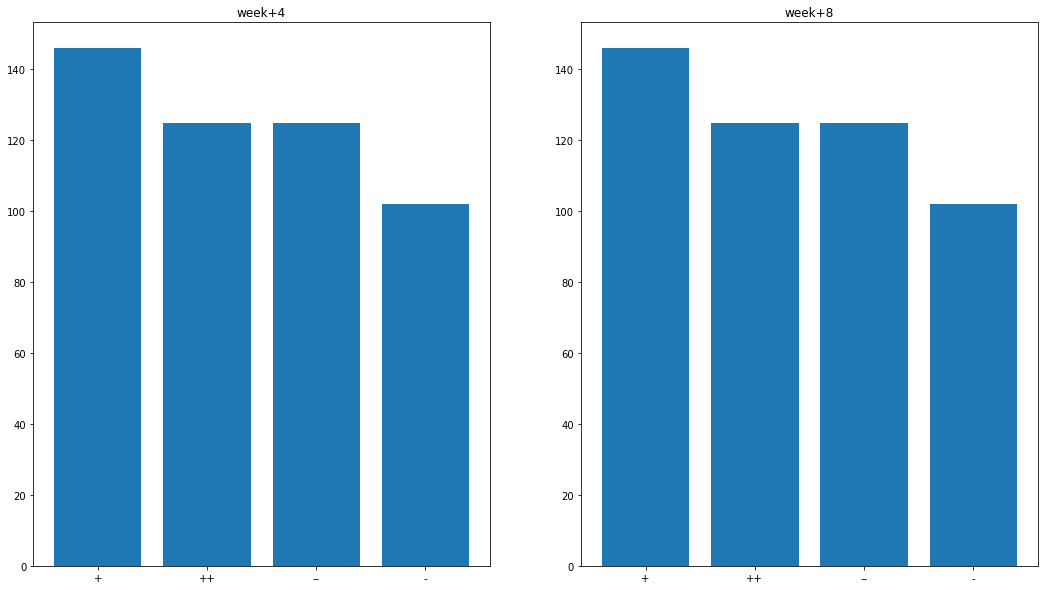

In [40]:
fig, ax = plt.subplots(1,2,figsize=(18,10))
ax = ax.flatten()

for ii in range(0,len(shifts)):
    ax[ii].bar(df_rig_shift['rig_change_4bin_week+'+str(shifts[ii])].value_counts().index.astype(str),df_rig_shift['rig_change_4bin_week+'+str(shifts[ii])].value_counts())
    ax[ii].set_title('week+'+str(shifts[ii]))

In [41]:
df_merge

,date,Cana Woodford,DJ-Niobrara,Eagle Ford,Permian,Williston,Total US RigCount,wti_spot_lag_15,wti_spot_lag_9,wti_spot,...,opec_tot_prod,opec_crud_capac,opec_surp_capac,non-opec_tot_prod,oecd_cons_smooth,oecd_cons,non-oecd_cons_smooth,non-oecd_cons,world_cons_smooth,world_cons
0,2020-10-09,6.0,4.0,12.0,129.0,11.0,193.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-10-02,6.0,4.0,11.0,128.0,11.0,189.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-09-25,6.0,4.0,11.0,123.0,10.0,183.0,38.3500,41.3380,39.780,...,29.435122,31.697833,7.094833,63.063193,41.3380,43.702403,41.3380,52.057515,41.3380,95.759918
3,2020-09-18,6.0,4.0,9.0,121.0,10.0,179.0,37.8720,40.5700,39.554,...,29.271614,31.666139,7.234639,62.993766,40.5700,43.415251,40.5700,52.199139,40.5700,95.614390
4,2020-09-11,6.0,4.0,9.0,122.0,9.0,180.0,37.3220,40.4420,37.375,...,29.108107,31.634444,7.374444,62.924340,40.4420,43.128099,40.4420,52.340763,40.4420,95.468862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,2011-03-04,14.0,12.0,55.0,337.0,162.0,801.0,82.2775,90.9660,101.052,...,33.374519,32.058716,3.681155,54.516960,90.9660,46.803132,90.9660,41.998207,90.9660,88.801339
502,2011-02-25,12.0,10.0,46.0,337.0,158.0,783.0,82.2340,89.6625,95.260,...,33.561034,32.244959,3.700494,54.462516,89.6625,47.114307,89.6625,42.042778,89.6625,89.157086
503,2011-02-18,12.0,10.0,46.0,347.0,158.0,798.0,86.9080,88.2680,84.134,...,33.894788,32.544776,3.700373,54.349691,88.2680,47.297406,88.2680,42.209481,88.2680,89.506888
504,2011-02-11,12.0,10.0,46.0,355.0,158.0,805.0,84.9280,88.4960,85.514,...,34.228542,32.844592,3.700252,54.236865,88.4960,47.480506,88.4960,42.376184,88.4960,89.856690


In [42]:
df_rig_shift

,date,Total US RigCount,rig_fut_week+4,rig_fut_week+8,rig_pct_change_week+4,rig_pct_change_week+8,rig_change_bin_week+4,rig_change_4bin_week+4,rig_change_bin_week+8,rig_change_4bin_week+8
0,2020-08-14,172.0,180.0,193.0,0.046512,0.122093,pos,++,pos,++
1,2020-08-07,176.0,181.0,189.0,0.028409,0.073864,pos,++,pos,++
2,2020-07-31,180.0,180.0,183.0,0.000000,0.016667,neg,-,pos,+
3,2020-07-24,181.0,183.0,179.0,0.011050,-0.011050,pos,+,neg,-
4,2020-07-17,180.0,172.0,180.0,-0.044444,0.000000,neg,--,neg,-
...,...,...,...,...,...,...,...,...,...,...
493,2011-03-04,801.0,877.0,927.0,0.094881,0.157303,pos,++,pos,++
494,2011-02-25,783.0,851.0,913.0,0.086845,0.166028,pos,++,pos,++
495,2011-02-18,798.0,839.0,880.0,0.051378,0.102757,pos,++,pos,++
496,2011-02-11,805.0,827.0,886.0,0.027329,0.100621,pos,++,pos,++


In [43]:
rig_col = df_rig_shift.columns[df_rig_shift.columns.str.contains('rig_change_4bin_week')].to_list() + ['date']

df_merge = df_merge.merge(df_rig_shift[rig_col],how='outer',on='date')

df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506 entries, 0 to 505
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    506 non-null    datetime64[ns]
 1   Cana Woodford           506 non-null    float64       
 2   DJ-Niobrara             506 non-null    float64       
 3   Eagle Ford              506 non-null    float64       
 4   Permian                 506 non-null    float64       
 5   Williston               506 non-null    float64       
 6   Total US RigCount       506 non-null    float64       
 7   wti_spot_lag_15         504 non-null    float64       
 8   wti_spot_lag_9          504 non-null    float64       
 9   wti_spot                504 non-null    float64       
 10  brent_spot              504 non-null    float64       
 11  wti_fut_1               504 non-null    float64       
 12  wti_fut_2               504 non-null    float64   

In [44]:
# Save merged file as CSV
df_merge.to_csv(data_interim_dir+'merged_data_weekly_class.csv',index=False)